In [2]:
!pip install mne
import mne

file_path = 'chb01_03.edf'
raw_data = mne.io.read_raw_edf(file_path, preload=True)

raw_data.info

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 15.6 MB/s eta 0:00:00
Extracting EDF parameters from /content/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-2-891023da2569>:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


Measurement date,"November 06, 2076 13:43:04 GMT"
Experimenter,Unknown
Participant,Surrogate
Digitized points,Not available
Good channels,23 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.00 Hz
Lowpass,128.00 Hz


Using matplotlib as 2D backend.


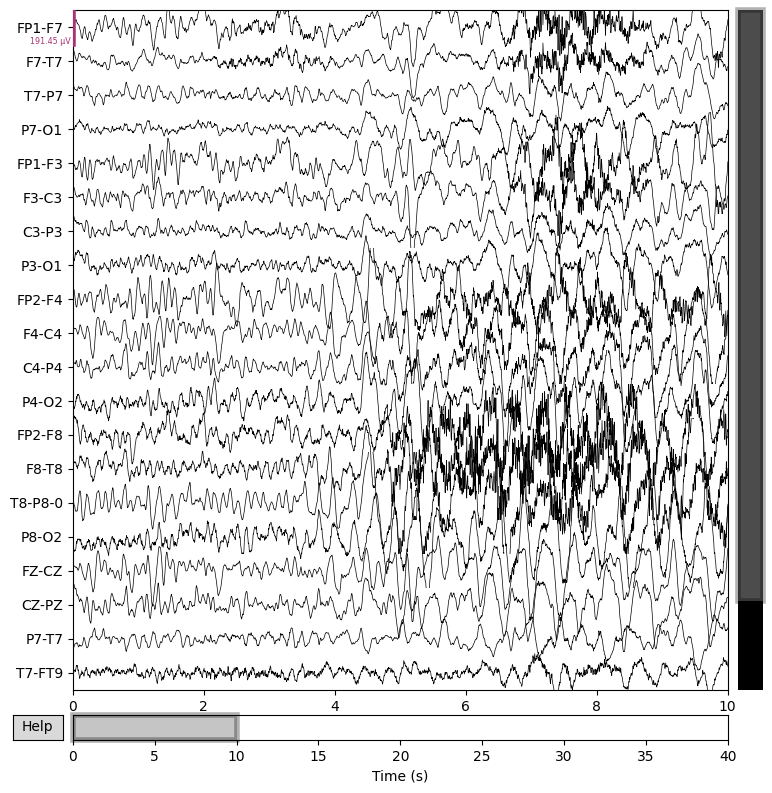

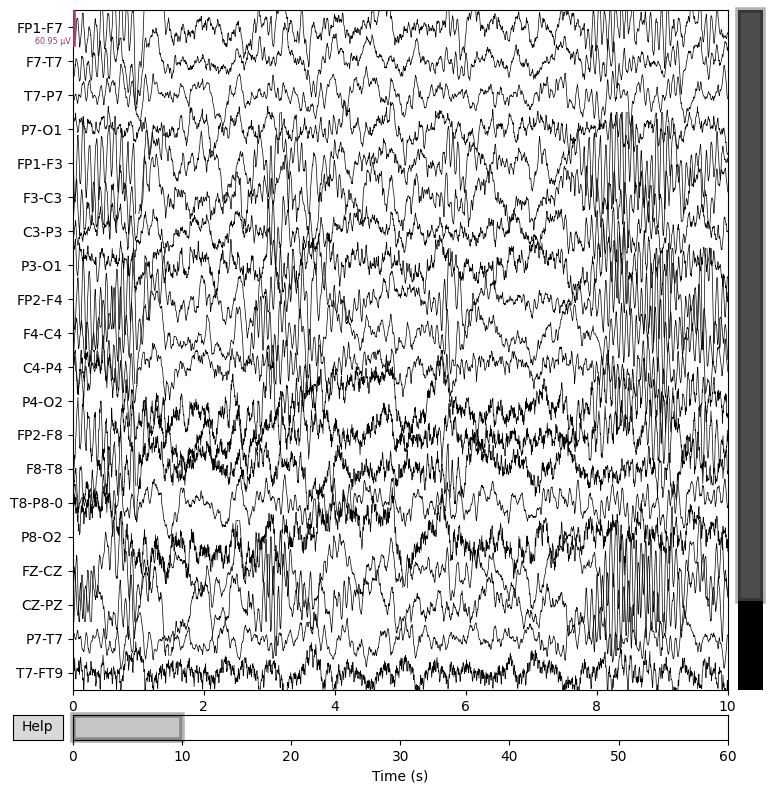

In [3]:

seizure_start = 2996
seizure_end = 3036

seizure_data = raw_data.copy().crop(tmin=seizure_start, tmax=seizure_end)

baseline_start = seizure_start - 60
baseline_end = seizure_start

baseline_data = raw_data.copy().crop(tmin=baseline_start, tmax=baseline_end)

import matplotlib.pyplot as plt
fig1 = seizure_data.plot(scalings='auto', title='Seizure EEG Data', show=False)
fig2 = baseline_data.plot(scalings='auto', title='Baseline EEG Data', show=False)

fig1.show()
fig2.show()

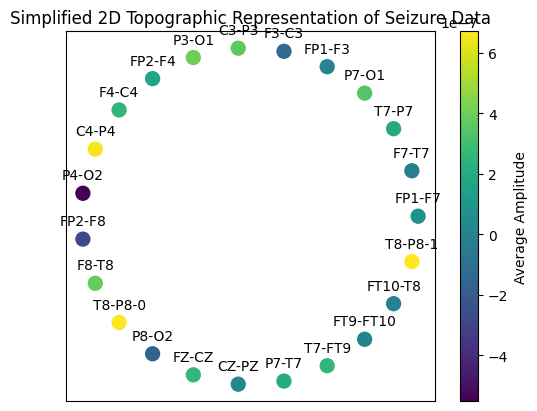

In [7]:
import numpy as np
channel_approx = {
    'FP1-F7': (-0.7, 0.5),
    'F7-T7': (-0.7, 0),
    'T7-P7': (-0.7, -0.5),
    'P7-O1': (-0.5, -0.7),
    'FP1-F3': (-0.3, 0.7),
    'F3-C3': (-0.3, 0),
    'C3-P3': (-0.3, -0.7),
    'P3-O1': (-0.1, -0.9),
    'FP2-F4': (0.3, 0.7),
    'F4-C4': (0.3, 0),
    'C4-P4': (0.3, -0.7),
    'P4-O2': (0.1, -0.9),
    'FP2-F8': (0.7, 0.5),
    'F8-T8': (0.7, 0),
    'T8-P8-0': (0.7, -0.5),
    'P8-O2': (0.5, -0.7),
    'FZ-CZ': (0, 0.1),
    'CZ-PZ': (0, -0.3),
    'P7-T7': (-0.7, -0.1),
    'T7-FT9': (-0.8, -0.1),
    'FT9-FT10': (-0.8, 0.1),
    'FT10-T8': (0.8, 0.1),
    'T8-P8-1': (0.7, -0.4)
}
n_channels = len(channel_approx)
theta = np.linspace(0, 2 * np.pi, n_channels, endpoint=False)
x = np.cos(theta)
y = np.sin(theta)
z = np.zeros(n_channels)
channel_dummy_positions = {ch: (x[i], y[i], z[i]) for i, ch in enumerate(channel_approx.keys())}
x_positions = [pos[0] for pos in channel_dummy_positions.values()]
y_positions = [pos[1] for pos in channel_dummy_positions.values()]
avg_seizure_data = seizure_data.get_data().mean(axis=1)
fig, ax = plt.subplots()
sc = ax.scatter(x_positions, y_positions, c=avg_seizure_data, cmap='viridis', s=100)
plt.colorbar(sc, ax=ax, label='Average Amplitude')
ax.set_aspect('equal', 'box')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Simplified 2D Topographic Representation of Seizure Data')

for i, txt in enumerate(channel_dummy_positions.keys()):
    ax.annotate(txt, (x_positions[i], y_positions[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


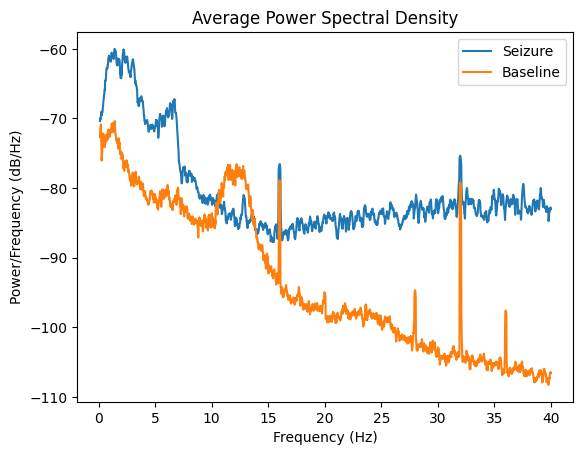

In [18]:
from mne.time_frequency import psd_array_multitaper

psd_seizure, freqs_seizure = psd_array_multitaper(seizure_data.get_data(), sfreq=seizure_data.info['sfreq'], fmin=0.1, fmax=40)
psd_baseline, freqs_baseline = psd_array_multitaper(baseline_data.get_data(), sfreq=baseline_data.info['sfreq'], fmin=0.1, fmax=40)

avg_psd_seizure = np.mean(psd_seizure, axis=0)
avg_psd_baseline = np.mean(psd_baseline, axis=0)

fig, ax = plt.subplots()
ax.plot(freqs_seizure, 10 * np.log10(avg_psd_seizure), label='Seizure')
ax.plot(freqs_baseline, 10 * np.log10(avg_psd_baseline), label='Baseline')
ax.set_title('Average Power Spectral Density')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power/Frequency (dB/Hz)')
ax.legend()
plt.show()


In [25]:
import tensorflow as tf
import mne
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np

file_path = 'chb01_03.edf'
raw = mne.io.read_raw_edf(file_path, preload=True)
raw.filter(1., 40., fir_design='firwin')
def create_events(raw, seizure_start, seizure_end, event_length=1.0):
    """Create events array with labels for seizure and non-seizure periods."""
    sfreq = raw.info['sfreq']
    n_samples = len(raw.times)
    start_sample = int(seizure_start * sfreq)
    end_sample = int(seizure_end * sfreq)

    non_seizure_events_start = np.arange(0, start_sample, int(event_length * sfreq))
    non_seizure_events_end = np.arange(int(event_length * sfreq), start_sample, int(event_length * sfreq))

    seizure_events = np.arange(start_sample, end_sample, int(event_length * sfreq))

    events = np.concatenate([non_seizure_events_start, seizure_events])
    labels = np.concatenate([np.zeros(len(non_seizure_events_start), dtype=int),
                             np.ones(len(seizure_events), dtype=int)])

    return np.column_stack([events, np.zeros_like(events), labels])

events, event_id = create_events(raw, seizure_start, seizure_end), {'Non-seizure': 0, 'Seizure': 1}

epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=0, tmax=epoch_duration, baseline=None, preload=True)

seizure_start, seizure_end = 2996, 3036
epoch_duration = 1.0
events = mne.make_fixed_length_events(raw, id=1, start=0, duration=epoch_duration)
event_dict = {'Non-seizure': 0, 'Seizure': 1}

labels = epochs.events[:, -1]

data = epochs.get_data()
data = data[..., np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(data.shape[1], data.shape[2], 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Extracting EDF parameters from /content/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-25-835003858dc0>:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Not setting metadata
3036 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3036 events and 257 original time points ...
0 bad epochs dropped


<ipython-input-25-835003858dc0>:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # (n_epochs, n_channels, n_times)


Epoch 1/10
76/76 [==============================] - 16s 183ms/step - loss: 0.1304 - accuracy: 0.9757 - val_loss: 0.0844 - val_accuracy: 0.9836
Epoch 2/10
76/76 [==============================] - 10s 130ms/step - loss: 0.0682 - accuracy: 0.9876 - val_loss: 0.0840 - val_accuracy: 0.9836
Epoch 3/10
76/76 [==============================] - 10s 126ms/step - loss: 0.0722 - accuracy: 0.9876 - val_loss: 0.0855 - val_accuracy: 0.9836
Epoch 4/10
76/76 [==============================] - 8s 111ms/step - loss: 0.0732 - accuracy: 0.9876 - val_loss: 0.0976 - val_accuracy: 0.9836
Epoch 5/10
76/76 [==============================] - 10s 126ms/step - loss: 0.0700 - accuracy: 0.9876 - val_loss: 0.0839 - val_accuracy: 0.9836
Epoch 6/10
76/76 [==============================] - 10s 133ms/step - loss: 0.0758 - accuracy: 0.9876 - val_loss: 0.0940 - val_accuracy: 0.9836
Epoch 7/10
76/76 [==============================] - 13s 165ms/step - loss: 0.0700 - accuracy: 0.9876 - val_loss: 0.0888 - val_accuracy: 0.9836
